In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import emcee
%matplotlib inline


Bad key "patch.force_edgecolor" on line 112 in
/Users/Emily/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "date.autoformatter.second" on line 364 in
/Users/Emily/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dashed_pattern" on line 97 in
/Users/Emily/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "boxplot.meanprops.markeredgecolor" on line 158 in
/Users/Emily/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master

In [2]:
class node:
    def __init__(self,nInput,nNode,nOut):
        self.val=0
        self.lastVal=0
        self.init=0
        self.wIn=np.zeros(nInput)
        self.wNode=np.zeros((nNode-1,2))
        self.wOut=np.zeros(nOut)

def initNetwork(nInput,nNode,nOut,wNodes): #setting up the network
    nodes=[]
    for i in range(nNode):
        newNode=node(nInput,nNode,nOut)
        for j in range(nInput):
            newNode.wIn[j]=1 #for the moment treat all inputs as equally important
        for j in range(nOut):
            newNode.wOut[j]=1 #the same for outputs
        #and initialise all other weights at random
        for j in range(nNode-1):
            whichLink=j
            if j>=i:
                whichLink=j+1
            newNode.wNode[j,0]=whichLink
            newNode.wNode[j,1]=wNodes[i][j]
        nodes.append(newNode)
    return nodes

def sig(x):
    return 1/(1+np.exp(-x))

#nInput=2
#nNode=5
#nOut=1

#nodes=initNetwork(nInput,nNode,nOut)
#for i in range(nNode):
#    print(nodes[i].wNode)

In [21]:
def reward(weights,nNode,nInput):
    """
    Calculates the absolute value of the difference between the network's output, "netOut," and the true
    training set output, "trueOut." (This is our "log likelihood;" since the network is only outputting a single number, 
    the absolute value is equivalent to the root-mean-square error of the outputs.)
    """
    wNodes=np.split(weights,nNode) #converts 1D array of shape (2*nNode,) into 2D array of shape (nNode, 2)
    inputs=np.random.random(nInput) #two random integers ("training set input")
    trueOut=np.sum(inputs) #sum of inputs ("training set output")
    
    nodes=initNetwork(nInput,nNode,1,wNodes)
    nodes=resetNodes(nodes,inputs)
    netOut=runNetwork(nodes,100)
    
    diff=trueOut-netOut
    
    RMSerr = -np.abs(diff) #equivalent to RMS = -np.sqrt(diff**2 / len(diff)) = -np.sqrt(diff**2 / 1)
    
    if np.isfinite(RMSerr)==False: #If RMSerr = -inf, then e**RMSerr = 0 (so this choice of weights is terrible, the walkers shouldn't go here)
        return -np.inf
    
    else: #else, return the RMS error, which is our "log likelihood." 
        return RMSerr

def resetNodes(nodes,inputs):
    for i in range(nNode):
        nodes[i].lastVal=0
        nodes[i].init=0
        for j in range(nInput):
            nodes[i].init=nodes[i].init+nodes[i].wIn[j]*inputs[j]
    return nodes

def runNetwork(nodes,nMax):
    #grid=mpl.gridspec.GridSpec(nStep)
    lastOutput=0
    for step in range(nMax):
        for i in range(nNode): #setting value of nodes back to zero (plus constant contribution from input)
            nodes[i].val=nodes[i].init
        
        for i in range(nNode): #adding contribution from all other nodes
            thisNode=nodes[i]
            for j in range(nNode-1):
                nodes[int(thisNode.wNode[j,0])].val+=thisNode.lastVal*thisNode.wNode[j,1]
    
        norm=1
        #for i in range(nNode): #recording the normalised values for the next step
        #    norm=norm+nodes[i].val
    
        for i in range(nNode): #recording the normalised values for the next step
            nodes[i].lastVal=nodes[i].val/norm
        
        output=0
        #print("_______At step ",step,' nodes have values:')
        for i in range(nNode):
            #print(i,": ",nodes[i].lastVal)
            output+=nodes[i].lastVal*nodes[i].wOut[0]
        #print("giving output: ",output)
        
        if (np.abs((output-lastOutput)/output)<0.01):
            return output
        lastOutput=output
    return output

In [22]:
#test run

#initialize number of inputs, outputs, internal interconnected nodes
nNode = 3
nInput = 2
nOut = 1

#initialize weights controlling connections between interconnected nodes
wNodes = np.random.uniform(0.,1.,(nNode,2))

In [23]:
#set up the network (must call resetNodes so that the input values are put into node.init)
testNodes = initNetwork(nInput,nNode,nOut,wNodes)
testNodes = resetNodes(testNodes,inputs=(-0.24,0.5))

"""for testNode in testNodes:
    print testNode.val
    print testNode.lastVal
    print testNode.init
    print testNode.wIn
    print testNode.wOut
    print testNode.wNode"""

#run the network for a max of 100 steps (if it doesn't converge sooner)
output = runNetwork(nodes=testNodes, nMax=100)

print output #in general, network doesn't converge and output blows up or oscillates step by step

3.4238871526


In [24]:
# now, we want to use emcee to optimize the weights controlling the connections between the internal
# interconnected nodes ("wNodes")
nWalkers=100
w0=[np.random.random(2*nNode) for i in range(nWalkers)]
print(np.shape(w0))

(100, 6)


In [25]:
sampler = emcee.EnsembleSampler(nwalkers=nWalkers, dim=2*nNode, lnpostfn=reward, args=[nNode,nInput])
sampler.run_mcmc(w0,100)

(array([[  1.68034199e+00,  -5.68727406e-01,  -2.19606921e+00,
          -4.25941215e-01,   8.24855951e-01,   7.02431098e-01],
        [ -8.20348968e+00,   3.99256162e+00,   7.79206807e-01,
           3.05310587e+00,   4.47242631e-01,   3.07231347e+00],
        [  2.64403555e+00,  -1.22690544e+00,  -3.04205540e-01,
           3.47375169e-02,  -3.63091910e-01,  -2.00523473e+00],
        [  2.15002807e+00,   2.40768959e+00,  -7.11654905e-02,
          -1.63640358e+00,   9.39930565e-01,   1.13343211e-01],
        [ -2.27297274e-01,   1.45470080e-01,  -3.53349505e+00,
          -5.77009819e-01,   5.13172489e+00,   2.93913836e+00],
        [  3.53872751e+00,   1.24057116e+00,   3.23053141e-01,
           6.53207385e-02,  -1.25921370e+00,  -8.23321936e-01],
        [ -2.07995614e-01,  -8.48737591e-01,  -1.55276145e-01,
          -6.20022769e-01,  -3.73497393e+00,   5.57821785e+00],
        [  2.54614021e+00,  -1.57856089e+00,  -1.62473167e-01,
          -4.65971356e-01,   2.51934509e-03,   7

In [26]:
print(np.shape(sampler.chain)) #shape = (nwalkers, nsteps, ndim)

(100, 100, 6)


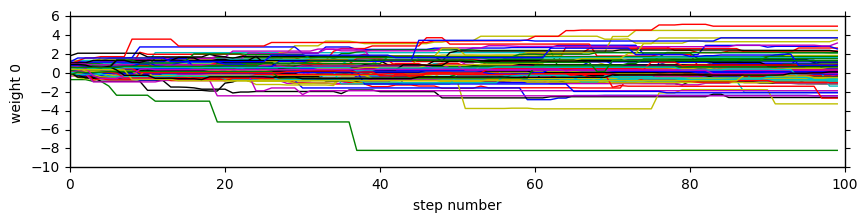

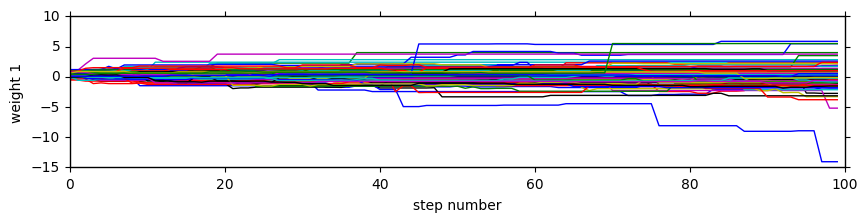

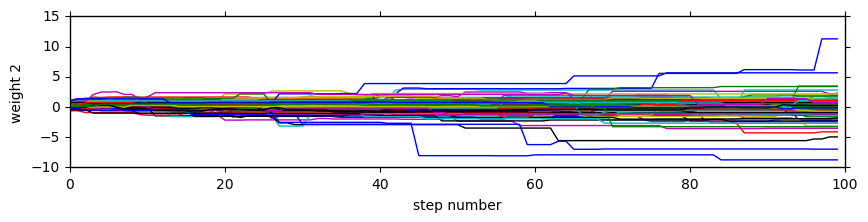

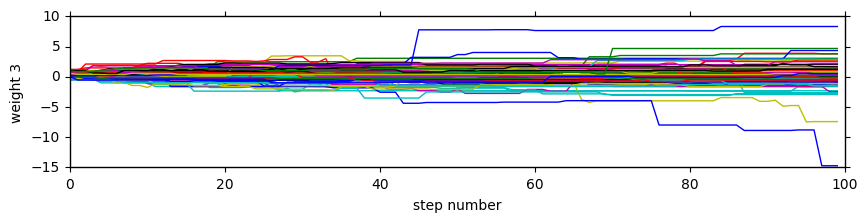

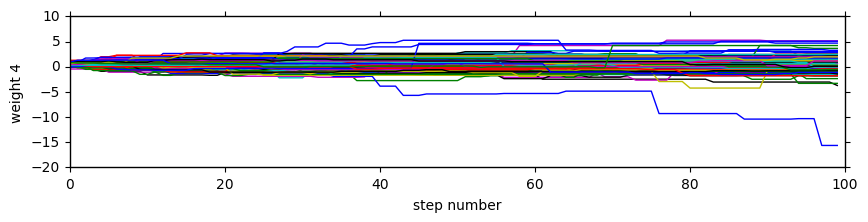

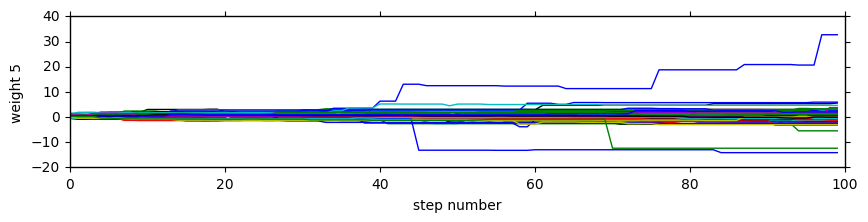

In [30]:
#Plot the chains to see what they're doing and if they're converging to any particular values of the weights
for i in range(2*nNode):
    fig = plt.figure(figsize=(10,2))

    for j in range(nWalkers):
        plt.plot(sampler.chain[j,:,i])
    
    plt.ylabel("weight {0}".format(i))
    plt.xlabel("step number")
    
    plt.show()

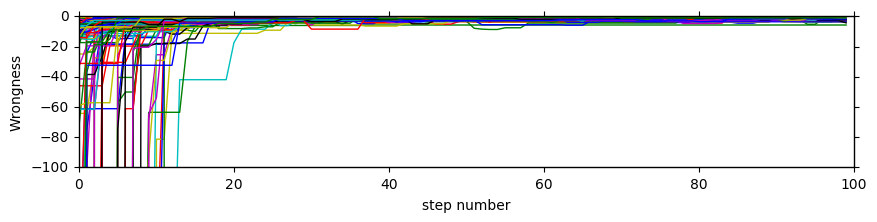

In [32]:
#See what the "log likelihood," aka distance between the network's guess and the truth, did over the 100-step run
# for each walker

fig = plt.figure(figsize=(10,2))

for j in range(nWalkers):
    plt.plot(sampler.lnprobability[j,:])
    
plt.ylabel("Wrongness")
plt.xlabel("step number")

plt.ylim(-100,0)
plt.show()

#So the network's performance does get better!!